In [2]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 1.5 MB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 1.1 MB/s eta 0:00:0000:0100:04
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
#from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

#pm.help()
#pm.reset()
#pm.init() #debug=True)
#cr_cp = pm.df('cr_cp')
#fe_cp = pm.df('fe_cp')
#cr_cp.info()
#fe_cp.info()

df_jo = pm.df('df_jo')
#df_jo.info()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])

df_jo_cp = df_jo.copy()

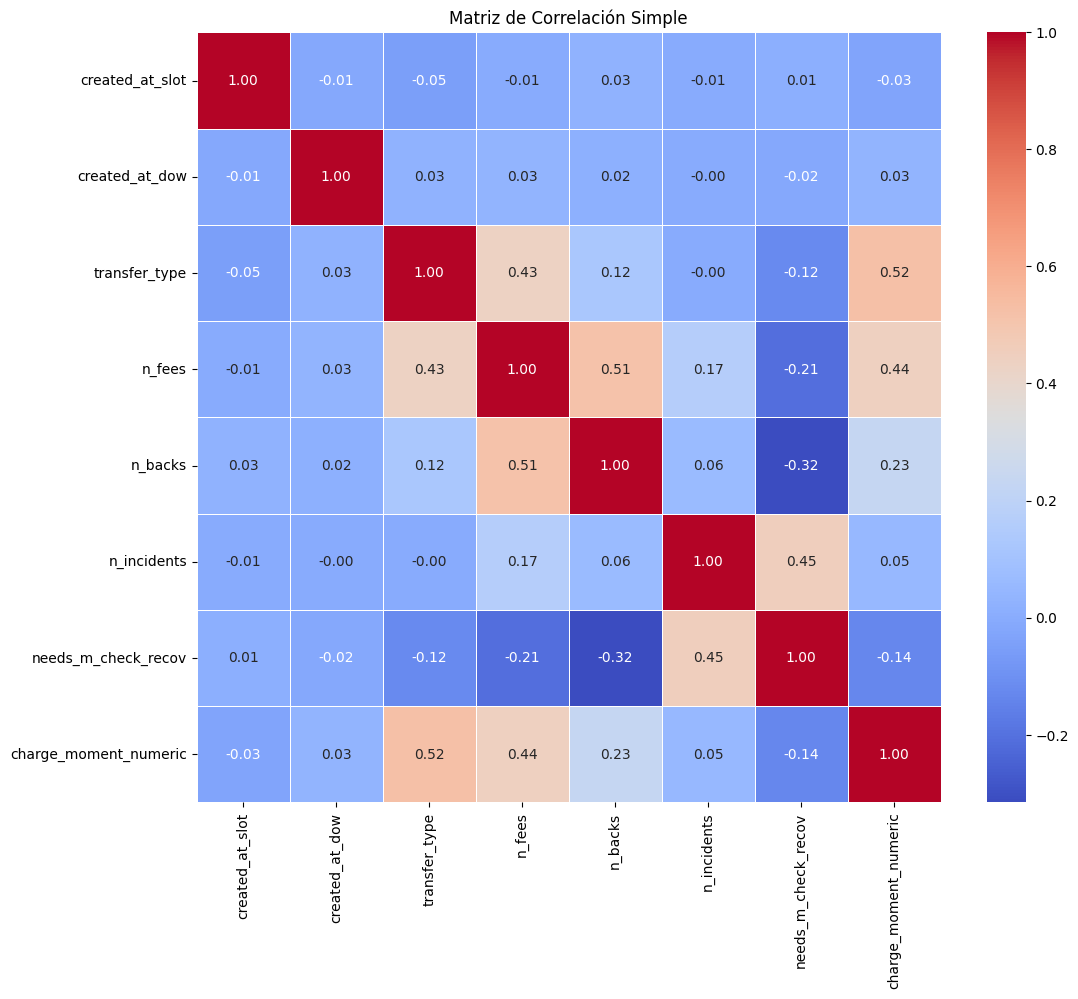

In [2]:
# Lista de columnas que deseas seleccionar del df_jo para el MODELO
columnas_deseadas = ['created_at_slot', 'created_at_dow' ,'transfer_type', 'n_fees', 'n_backs','n_incidents','charge_moment', 'needs_m_check_recov']

# Crear un nuevo DataFrame solamente con esas columnas
df_simpl = df_jo_cp[columnas_deseadas]

# Reasignar valores en la columna 'transfer_type'
df_simpl = df_simpl.copy()
df_simpl['transfer_type'] = df_simpl['transfer_type'].map({'regular': 0, 'instant': 1})
df_simpl['charge_moment_numeric'] = df_simpl['charge_moment'].fillna('null').map({
    'before': 0,
    'after': 1,
    'null': -1  # Asigna -1 para los valores nulos llenados como 'null'
})
df_simpl=df_simpl.drop(columns=['charge_moment'])

# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()

In [3]:
df_simpl['created_at_slot']= pd.to_numeric(df_simpl['created_at_slot'], errors='coerce')

In [5]:
# Modelo XGBoost

# Crea la matriz de características y la var objetivo
X = df_simpl.drop(columns=['needs_m_check_recov'])  # Elimina la columna objetivo
y = df_simpl['needs_m_check_recov']  # La columna de la variable objetivo

# Divide los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

# Crea el modelo XGBoost
model = XGBClassifier(eval_metric='logloss')

# Entrena el modelo
model.fit(X_train, y_train)

# Realiza predicciones
y_pred = model.predict(X_test)

# Calcula la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión: {accuracy:.2f}")


Precisión: 0.92


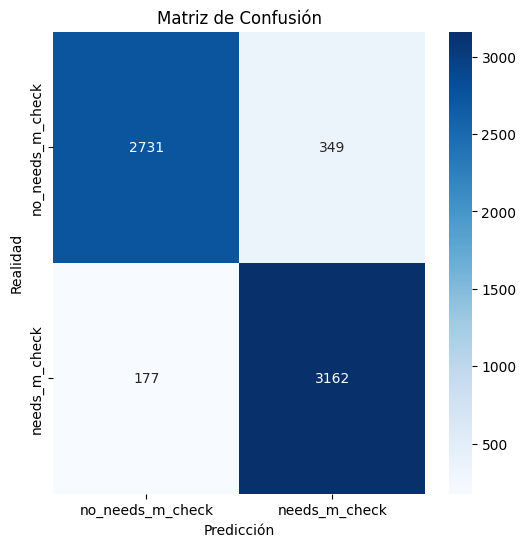

In [6]:
# Calcula la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualiza la matriz de confusión con un mapa de calor
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no_needs_m_check', 'needs_m_check'], yticklabels=['no_needs_m_check', 'needs_m_check'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

[[2452  628]
 [  11 3328]]
              precision    recall  f1-score   support

           0       1.00      0.80      0.88      3080
           1       0.84      1.00      0.91      3339

    accuracy                           0.90      6419
   macro avg       0.92      0.90      0.90      6419
weighted avg       0.92      0.90      0.90      6419

ROC AUC Score: 0.90


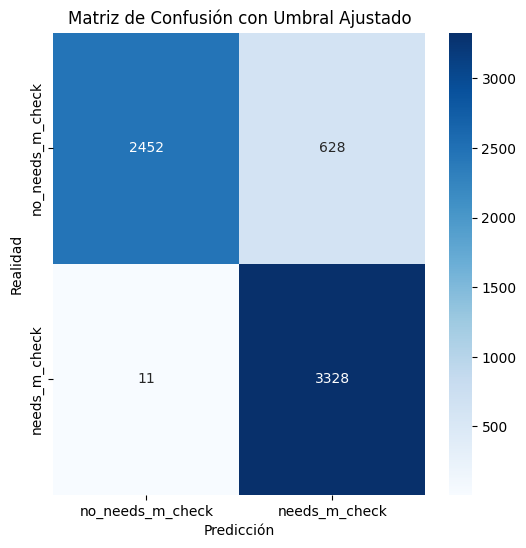

In [16]:

from sklearn.metrics import roc_auc_score, roc_curve

# Ajuste de parámetros en el modelo XGBoost
model = XGBClassifier(
    
    eval_metric='auc',  # Métrica de evaluación ROC AUC (para ver qué tan bien discrimina las clases)
    scale_pos_weight=1,   # Ajustar este valor según el desbalance de clases (num negativos/num postivos)
    max_delta_step=1,       # Puede ayudar a mejorar la estabilidad
    learning_rate=0.01,     # Disminuir esta tasa implica q el modelo aprende más lento pero más robustamente
    subsample=0.8,          # Muestreo del 80% de los datos, modelo más generalizable, evita sobreajuste y ayuda a redicir Falsos Negativos
    colsample_bytree=0.8    # Muestreo de las columnas
)

# Entrenamiento del modelo
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase 1

# Ajustar el umbral
threshold = 0.4  # Usar un umbral menor que 0.5
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Evaluación
print(confusion_matrix(y_test, y_pred_adjusted))
print(classification_report(y_test, y_pred_adjusted))
# Calcula el AUC
auc_score = roc_auc_score(y_test, y_pred_adjusted)
print(f"ROC AUC Score: {auc_score:.2f}")

# Matriz de confusión con ajuste de umbral
cm = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no_needs_m_check', 'needs_m_check'], yticklabels=['no_needs_m_check', 'needs_m_check'])
plt.title('Matriz de Confusión con Umbral Ajustado')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()